# Guided Project: Predicting Car Prices

## Introduction

The goal of this project is to practice the machine learning workflow studied in the course on the k-nearest neighbors algorithm to predict a car's market price using its attributes.

## Librairies and Modules Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = 99

## The Data

The data set we will be working with contains information on various cars. For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more.

The data set can be downloaded directly from [here](https://archive.ics.uci.edu/ml/datasets/automobile).

Let's read the data in!

In [2]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

cars = pd.read_csv('imports-85.data', names=cols)

cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


To train a model and make predictions, we need to isolate one or several numeric columns that will serve as predictive features and a unique target numeric column.

We start by creating a new dataframe that will contain only the numeric columns from the original dataframe.

In [3]:
numeric_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size',
                          'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

numeric_cars = cars[numeric_values_cols]

numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


Some or all of these columns could help us predict the price of a new car. But before we dive into the model training and prediction, let's start by cleaning `numeric_cars`.

## Data Cleaning

Based on the data set preview of the last section, we can list the following cleaning actions needed:
* Replace all "?" in `normalized-losses` by NaNs.
* Convert all columns in `numeric_cars` to numeric type.
* Deal with missing values in other numeric columns.
* Rescale values

### Replacing "?" in `normalized-losses`

Based on the data set preview from the last step, we can tell that the `normalized-losses` column contains missing values represented using "?". 

Let's start by replacing these values by NaN.

In [4]:
numeric_cars = numeric_cars.replace("?", np.nan)
numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,NaN,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


Because "?" is a string value, columns containing this value were cast to the pandas object data type (instead of a numeric type like int or float).

### Converting to numeric type

Now that we have replaced the "?" values, we need to determine which columns need to be converted to numeric types.

In [5]:
numeric_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  164 non-null    object 
 1   wheel-base         205 non-null    float64
 2   length             205 non-null    float64
 3   width              205 non-null    float64
 4   height             205 non-null    float64
 5   curb-weight        205 non-null    int64  
 6   engine-size        205 non-null    int64  
 7   bore               201 non-null    object 
 8   stroke             201 non-null    object 
 9   compression-rate   205 non-null    float64
 10  horsepower         203 non-null    object 
 11  peak-rpm           203 non-null    object 
 12  city-mpg           205 non-null    int64  
 13  highway-mpg        205 non-null    int64  
 14  price              201 non-null    object 
dtypes: float64(5), int64(4), object(6)
memory usage: 24.1+ KB


Several columns are of object type although they contain continuous numerical data. We convert all of them to numeric type.

In [6]:
numeric_cars = numeric_cars.astype(float)

### Missing Values

We now need to deal with missing values in all the other numeric columns. Here are the number of missing values for each column.

In [7]:
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

There are several ways to handle columns with missing values:
* Replace the missing values using the average values from that column.
* Drop the rows entirely (especially if other columns in those rows have missing values).
* Drop the column entirely.

Because `price` is the column we want to predict, let's start by removing any rows with missing `price` value.

In [8]:
numeric_cars = numeric_cars.dropna(subset=['price'])
numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,NaN,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0
2,NaN,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0
3,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
4,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0


In [9]:
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

The rows with missing `price` values have been correctly dropped.

After that, we decide to replace missing values in other columns by their respective means.

In [10]:
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

We managed to deal with all the missing values.

### Rescaling

Finally, we normalize all the numeric columns we decided to keep (except for the target column) so all values range from 0 to 1.

In [11]:
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price_col

numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


Our dataset is now ready! We can now start creating and training models for price prediction. 

We will start by creating some simple univariate k-nearest neighbor models. Starting with simple models before moving to more complex models helps structure the code workflow and understand the features better.

## Univariate k-Nearest Neighbor Model

We start by creating a function that encapsulates the training and simple validation process.

In [12]:
def univariate_knn(train_name, target_name, df):
    model = KNeighborsRegressor()
    np.random.seed(1)
    
    # Randomize the order of rows in the dataframe
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Divide the number of rows in half and round
    last_train_row = int(len(df)/2)
    
    # Split df in a training and a testing sets
    train_set = rand_df.iloc[0:last_train_row]
    test_set = rand_df.iloc[last_train_row:]
    
    # Fit the model
    model.fit(train_set[[train_name]], train_set[target_name])
    
    # Make the predictions
    predictions = model.predict(test_set[[train_name]])
    
    # Calculate the RMSE
    mse = mean_squared_error(test_set[target_name], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

We use this function to train and test univariate models using each individual numeric column in our data set.

In [13]:
features = numeric_cars.columns.drop('price')

rmse_results = {}

for f in features:
    rmse = univariate_knn(f, 'price', numeric_cars)
    rmse_results[f] = rmse
    
# We create a Series object from the dictionnary for better visualization and sorting
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values(inplace=True)
print(rmse_results_series)

engine-size          3238.462830
horsepower           4037.037713
curb-weight          4401.118255
highway-mpg          4630.026799
width                4704.482590
city-mpg             4766.422505
length               5427.200961
wheel-base           5461.553998
compression-rate     6610.812153
bore                 6780.627785
normalized-losses    7330.197653
peak-rpm             7697.459696
stroke               8006.529545
height               8144.441043
dtype: float64


Using the default k value, the `engine_size` feature is the one that performed the best at predicting the price.

We now modify our `knn_train_test()` function to accept a parameter for the k value.

In [14]:
def univariate_knn_v2(train_name, target_name, df, k):
    model = KNeighborsRegressor(n_neighbors=k)
    np.random.seed(1)
    
    # Randomize the order of rows in the dataframe
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Divide the number of rows in half and round
    last_train_row = int(len(df)/2)
    
    # Split df in a training and a testing sets
    train_set = rand_df.iloc[0:last_train_row]
    test_set = rand_df.iloc[last_train_row:]
    
    # Fit the model
    model.fit(train_set[[train_name]], train_set[target_name])
    
    # Make the predictions
    predictions = model.predict(test_set[[train_name]])
    
    # Calculate the RMSE
    mse = mean_squared_error(test_set[target_name], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

For each numeric column we create, train and test a univariate model using the following k values (1, 3, 5, 7 and 9).

In [15]:
features = numeric_cars.columns.drop('price')
k_values = [1, 3, 5, 7, 9]
rmse_results = {}

for f in features:
    k_rmse_results = {}
    for k in k_values:
        rmse = univariate_knn_v2(f, 'price', numeric_cars, k)
        k_rmse_results[k] = rmse
    rmse_results[f] = k_rmse_results
    
rmse_results

{'normalized-losses': {1: 7846.750605148984,
  3: 7500.5698123109905,
  5: 7330.197653434445,
  7: 7756.421586234123,
  9: 7688.096096891432},
 'wheel-base': {1: 4493.734068810494,
  3: 5120.161506064513,
  5: 5461.553997873057,
  7: 5448.1070513823315,
  9: 5738.405685192312},
 'length': {1: 4628.45550121557,
  3: 5129.8358210721635,
  5: 5427.2009608367125,
  7: 5313.427720847974,
  9: 5383.054514833446},
 'width': {1: 4559.257297950061,
  3: 4606.413692169901,
  5: 4704.482589704386,
  7: 4571.485046194653,
  9: 4652.914172067787},
 'height': {1: 8904.04645636071,
  3: 8277.609643045525,
  5: 8144.441042663747,
  7: 7679.598124393773,
  9: 7811.03606291223},
 'curb-weight': {1: 5264.290230758878,
  3: 5022.318011757233,
  5: 4401.118254793124,
  7: 4330.608104418053,
  9: 4632.044474454401},
 'engine-size': {1: 3258.4861059962027,
  3: 2840.562805643501,
  5: 3238.4628296477176,
  7: 3563.086774256415,
  9: 3831.8244149840766},
 'bore': {1: 8602.58848450066,
  3: 6984.239489480916,


We visualize the rmse results for each feature and each k value using a line plot.

[1, 3, 5, 7, 9]
[7846.750605148984, 7500.5698123109905, 7330.197653434445, 7756.421586234123, 7688.096096891432]
[1, 3, 5, 7, 9]
[4493.734068810494, 5120.161506064513, 5461.553997873057, 5448.1070513823315, 5738.405685192312]
[1, 3, 5, 7, 9]
[4628.45550121557, 5129.8358210721635, 5427.2009608367125, 5313.427720847974, 5383.054514833446]
[1, 3, 5, 7, 9]
[4559.257297950061, 4606.413692169901, 4704.482589704386, 4571.485046194653, 4652.914172067787]
[1, 3, 5, 7, 9]
[8904.04645636071, 8277.609643045525, 8144.441042663747, 7679.598124393773, 7811.03606291223]
[1, 3, 5, 7, 9]
[5264.290230758878, 5022.318011757233, 4401.118254793124, 4330.608104418053, 4632.044474454401]
[1, 3, 5, 7, 9]
[3258.4861059962027, 2840.562805643501, 3238.4628296477176, 3563.086774256415, 3831.8244149840766]
[1, 3, 5, 7, 9]
[8602.58848450066, 6984.239489480916, 6780.627784685976, 6878.097965921532, 6866.808502038413]
[1, 3, 5, 7, 9]
[9116.495955406906, 7338.68466990294, 8006.529544647101, 7803.937796804327, 7735.5543

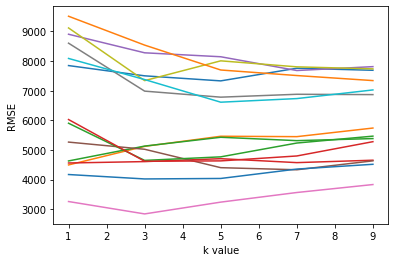

In [16]:
for f, k in rmse_results.items():
    x = list(k.keys())
    y = list(k.values())
    print(x)
    print(y)
    
    plt.plot(x, y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

We can finally average the RMSE values over the different k values for each feature and sort the features on that average. This will give us a list of our features ordered by performance at prediction.

In [17]:
# Compute average RMSE across different k values for each feature.
feature_avg_rmse = {}

for k, v in rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
    
series_avg_rmse = pd.Series(feature_avg_rmse)
sorted_avg_rmse = series_avg_rmse.sort_values()

print(sorted_avg_rmse)

sorted_features = sorted_avg_rmse.index.tolist()

engine-size          3346.484586
horsepower           4219.377860
width                4618.910560
curb-weight          4730.075815
highway-mpg          5069.469256
length               5176.394904
city-mpg             5202.409003
wheel-base           5252.392462
compression-rate     7166.073599
bore                 7222.472445
normalized-losses    7624.407151
stroke               8000.240467
peak-rpm             8119.365233
height               8163.346266
dtype: float64


Now that we experimented with a simple univariate model, we can move on to a more complex, multivariate model.

## Multivariate K-Nearest Neighbor Model

Let's now modify the function we wrote in the previous section to work with multiple features. 

We'll first implement a simple validation and then a k-fold cross validation to see if it improves the model's performance.

### With Simple Validation

In [18]:
def multivariate_knn_simple(train_name, target_name, df, k=5):
    
    model = KNeighborsRegressor()
    np.random.seed(1)

    # Randomize the order of rows in the dataframe
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Divide the number of rows in half and round
    last_train_row = int(len(df)/2)
    
    # Split df in a training and a testing sets
    train_set = rand_df.iloc[0:last_train_row]
    test_set = rand_df.iloc[last_train_row:]
    
    # Fit the model
    model.fit(train_set[train_name], train_set[target_name])
    
    # Make the predictions
    predictions = model.predict(test_set[train_name])
    
    # Calculate the RMSE
    mse = mean_squared_error(test_set[target_name], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

We train and evaluate this model on an incremental number of best features as ranked in the previous section.

In [19]:
rmse_results = {}

for nbr_features in range(2,7):
    rmse = multivariate_knn_simple(sorted_features[:nbr_features], 'price', numeric_cars)
    rmse_results[nbr_features] = rmse
    
# We create a Series object from the dictionnary for better visualization and sorting
rmse_results_series = pd.Series(rmse_results)
print(rmse_results_series)

2    2949.881728
3    3580.737665
4    3487.340917
5    3410.217013
6    3478.510890
dtype: float64


We can observe that, using the default k value of 5, the model trained on the 2 best features gives the best results (lowest RMSE).

Interestingly, training our model on the 3 best features gives worse predictions that training it on the 5 best ones. But training it with the 3 best features gives worse results than training it with the 2 best ones.

This behaviour must be due to some features interactions, showing how important it is to wisely select the relevant features for training and prediction. Increasing the number of features doesn't always comes with an increase in performance.

Let's now implement and observe the effect of k-fold cross validation.

### With K-Fold Cross Validation

In the previous section, we observed that our multivariate model performed the best when trained on the 2 best features only.

We now implement a k-fold cross validation and compare the performances for different number of folds.

We start by creating a new function named `multivariate_knn_kfold`.

In [20]:
def multivariate_knn_kfold(train_name, target_name, df, n_folds=2, k=5):
    
    model = KNeighborsRegressor(n_neighbors=k)
    kf = KFold(n_folds, shuffle=True, random_state=1)
    
    mses = cross_val_score(model, df[train_name], df[target_name], scoring="neg_mean_squared_error", cv=kf)

    avg_rmse = np.sqrt(np.absolute(np.mean(mses)))

    return avg_rmse

Then, we execute this function looping through increasing numbers of folds, from 2 to 10 folds.

In [21]:
rmse_results = {}

for n_folds in range(2,10):
    rmse = multivariate_knn_kfold(sorted_features[:2], 'price', numeric_cars, n_folds, k=5)
    rmse_results[n_folds] = rmse
    
# We create a Series object from the dictionnary for better visualization and sorting
rmse_results_series = pd.Series(rmse_results).sort_values()
print(rmse_results_series)

5    2994.872804
6    3008.312991
9    3010.326543
8    3010.923841
7    3037.288732
4    3096.942358
3    3116.775690
2    3298.149692
dtype: float64


We can observe a increase in performance (rmse drop) as we increase progressively the number of folds from 2 to 5, with a minimum of of the rmse value at 5 folds. For more than 5 folds, no further improvement is noticable.

However, implementing k-fold cross validation didn't decrease the RMSE compared to simple validation. It may still be that the variance is reduced when using a k-fold cross validation compared  to a simple one.

In the final section, we optimize our multivariate model by performing some hyperparameter tuning.

## Hyperparameter Tuning

In this section, we want to optimize our model by tuning the hyperparameter k.

For this optimization, we will train our model on the 2 best features only and with a 5-fold cross validation. We will vary the hyperparameter k value from 1 to 25 and plot the resulting RMSE results.

In [22]:
rmse_results = {}
n_best_features = [2, 3, 4, 5, 6]

for nbf in n_best_features:   
    k_rmse_results = {}
    for k in range(1,26):
        rmse = multivariate_knn_kfold(sorted_features[:nbf], 'price', numeric_cars, 5, k)
        k_rmse_results[k] = rmse
    rmse_results['{} best features'.format(nbf)] = k_rmse_results
    
rmse_results

{'2 best features': {1: 3156.615324126808,
  2: 2808.683104932439,
  3: 2954.7201265488857,
  4: 2989.036473825596,
  5: 2994.872803943433,
  6: 3031.7685120984906,
  7: 3215.166839683982,
  8: 3299.080860048383,
  9: 3373.9483913964045,
  10: 3521.6851128018943,
  11: 3657.3191830802834,
  12: 3813.6694664040947,
  13: 3915.418502771097,
  14: 3954.8665975753656,
  15: 3978.7174534813853,
  16: 4038.1232003230807,
  17: 4101.113382750669,
  18: 4150.8603537152685,
  19: 4200.801876269579,
  20: 4265.922843423243,
  21: 4346.637827621639,
  22: 4418.952964805866,
  23: 4501.671354905083,
  24: 4570.465931363428,
  25: 4625.085700692438},
 '3 best features': {1: 3032.4417643856314,
  2: 2864.692640586506,
  3: 2866.0902922860932,
  4: 2966.664150467526,
  5: 3148.810084459703,
  6: 3326.8230931358044,
  7: 3389.0520729627133,
  8: 3454.5727775438163,
  9: 3500.504689223516,
  10: 3501.1053742488107,
  11: 3509.0060163988555,
  12: 3610.901239081255,
  13: 3709.8380828636996,
  14: 3841.

Let's finally find out which k value is optimal for each model and how different they are.

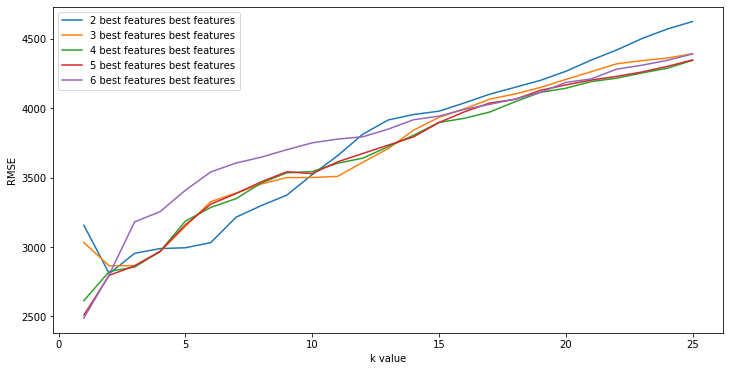

In [23]:
plt.figure(figsize=(12,6))

for k, v in rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    plt.plot(x,y, label='{} best features'.format(k))


plt.xlabel('k value')
plt.ylabel('RMSE')
plt.legend(loc = 'upper left')

As we can see, increasing the number of neighbors yields a higher RMSE meaning a decrease in performance, no matter how many best features we choose.

For low k values, taking only 2 or 3 of the best features seems to yield worse performances.

To get the lowest RMSE, we should then go for a model trained on the best 4, 5 or 6 features and take a k value inferior to 2. However, considering such a low number of nearest neighbors is likely to increase the variance in our predictions.
If we want to have lower variance, we should increase the k value to 5. At such a k value, the model trains on only the 2 best features seems to be the one that performed the best.

## Conclusion

In this project, we trained both univariate and multivariate k-nearest neighbors models to predict cars prices.

Experimenting with an univariate model trained successively on each individual numeric column allowed us to rank the features in order of individual performance.

From there, we moved on to a more complex model taking into account several features at a time. We observed a significant increase in prediction performance when combining several features by order of individual performance compared to a univariate model.
This experiment showed us how important the combination of features is on the performance of the model.
We observed that performance doesn't always increase with the number of features considered.
We also implemented a k-fold cross validation and observed that it did not necessarily decrease the RMSE but may have an impact on the variance.

Finally, we tuned our model by varying the k hyperparameter and observed that differences in performance between several models vary with the number of neighbors considered. We also observed that increasing the number of k values makes the RMSE increase (but may decrease the variance).

We were able to conclude that the best model is the one trained on the features `engine-size` and `horsepower` with a k value of around 5.